> ### EEE6503-01: Computer Vision

# Final Project: Domain Generalization

**<div style="text-align: right"> Due date: Dec 17th, 2024. </div>** 
**<div style="text-align: right"> Please upload your file @ learnus by 11:00 PM. </div>** 

### *Assignment Instructions:*
1. Write a program implementing a particular algorithm to solve a given problem.
2. You can use both Korean and English for your report.
3. **Analyze the algorithm, theoretically and empirically.** 
4. **Report your results.**   

<h2><span style="color:blue">[Insert your Team ID HERE]</span> </h2>

In [1]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2024-11-17 19:54:08.112635


The objective of this assignment is to address the domain generalization problem in neural networks.

In [20]:
# You may change the values below.
team_id = '000' # your team id - should be a three-digit number
root_dir = './조별과제/work/datasets/PACS' # directory to the dataset
lr = 0.0001 # learning rate
step_size = 7 # scheduler step size (if used)

# You must not change the values below.
num_epochs = 10 # number of epochs
image_size = 64 # input image size
batch_size = 32 # batch size for training
model_name = f'{team_id}_model.pth' # model name
TEST_MODE = False # test mode -- evaluation for TAs

In [21]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import ConcatDataset, DataLoader, Dataset
from torchvision import models
from torchvision.transforms import transforms
from tqdm import tqdm

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [22]:
class PACSDataset(Dataset):
	def __init__(self, root_dir, domain, transform=None):
		"""
		Args:
			root_dir (string): Directory with all the images.
			domains (list): Containing domains of interest, with element choices: 
				['photo', 'art_painting', 'cartoon', 'sketch'].
			transform (callable, optional): Optional transform to be applied on a sample.
		"""        
		self.root_dir = root_dir
		self.domain = domain
		self.transform = transform

		self.classes = ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']
		self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

		self.images = []
		self.labels = []

		# Load images and labels
		domain_dir = os.path.join(self.root_dir, self.domain)
		for cls_name in self.classes:
			cls_dir = os.path.join(domain_dir, cls_name)
			image_files = [f for f in os.listdir(cls_dir) if f.lower().endswith(('.jpg', '.png'))]

			for img_name in image_files:
				self.images.append(os.path.join(cls_dir, img_name))
				self.labels.append(self.class_to_idx[cls_name])

	def __len__(self):
		return len(self.images)

	def __getitem__(self, idx):
		img_path = self.images[idx]
		image = Image.open(img_path).convert('RGB')
		label = self.labels[idx]

		if self.transform:
			image = self.transform(image)

		return image, label

In [ ]:
# Define transforms
transform_train = transforms.Compose([
	transforms.Resize((image_size, image_size)),
	transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
	transforms.ToTensor(),
	transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
	])

transform_test = transforms.Compose([
	transforms.Resize((image_size, image_size)),
	transforms.ToTensor(),
	transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
	])

In [33]:
# Create datasets
dataset_train = ConcatDataset([
	PACSDataset(root_dir, 'cartoon', transform=transform_train),
	PACSDataset(root_dir, 'art_painting', transform=transform_train),
	PACSDataset(root_dir, 'sketch', transform=transform_train),
	])

dataset_test = PACSDataset(root_dir, 'photo', transform=transform_test)

loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [34]:
# Let's visualize some images from the training set

import matplotlib.pyplot as plt
import numpy as np

def visualize_example_images(root_dir, domain):
	assert domain in ['art_painting', 'sketch', 'cartoon']

	def denormalize(tensor):
		"""Denormalize the image tensor for visualization"""
		mean = torch.tensor([0.485, 0.456, 0.406]).reshape(3, 1, 1)
		std = torch.tensor([0.229, 0.224, 0.225]).reshape(3, 1, 1)
		return tensor * std + mean
	
 	# Create dataset
	dataset = PACSDataset(root_dir=root_dir, domain=domain, transform=transform_test)

	# Create a figure with subplots for each class
	fig, axs = plt.subplots(1, 7, figsize=(15, 3))
	fig.suptitle('Sample Images from Each Category')

	# For each class
	for i, class_name in enumerate(dataset.classes):
		# Find first image of this class
		for idx in range(len(dataset)):
			if dataset.labels[idx] == i:
				image, _ = dataset[idx]
				
				# Denormalize the image
				image = denormalize(image)
				
				# Convert to numpy and transpose for plotting
				image = image.numpy().transpose(1, 2, 0)
				
				# Clip values to [0, 1] range
				image = np.clip(image, 0, 1)
				
				# Plot
				axs[i].imshow(image)
				axs[i].set_title(class_name)
				axs[i].axis('off')
				break

	plt.tight_layout()
	plt.show()

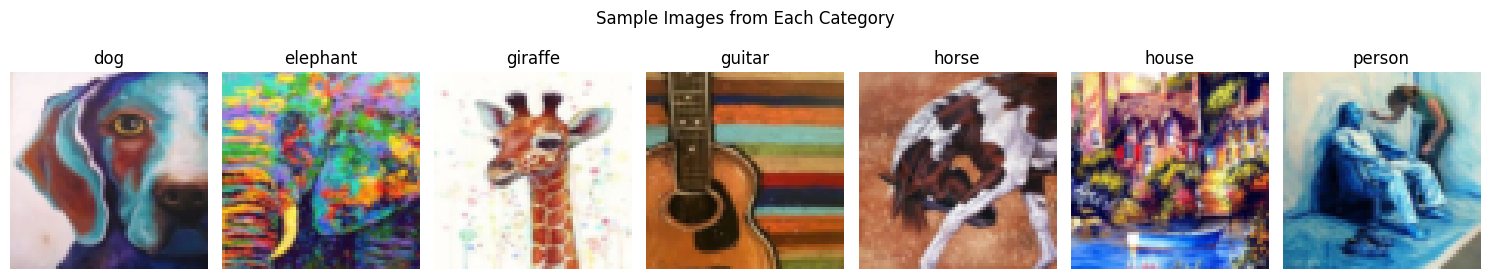

In [35]:
visualize_example_images(root_dir, 'art_painting')

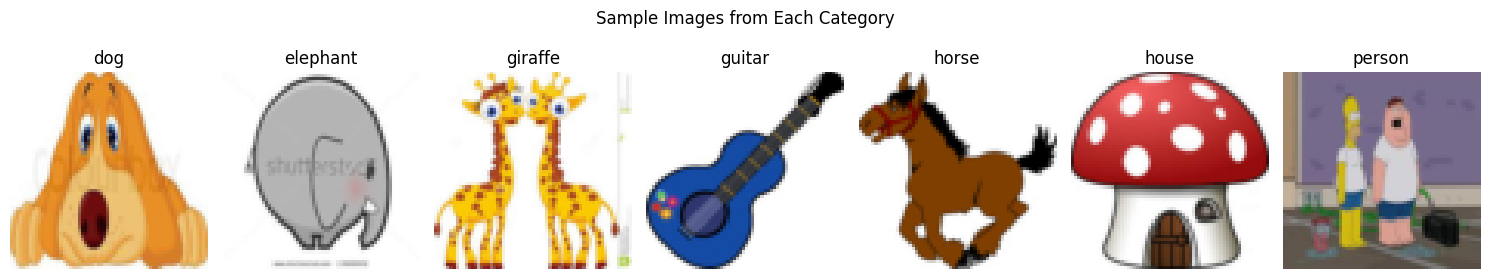

In [8]:
visualize_example_images(root_dir, 'cartoon')

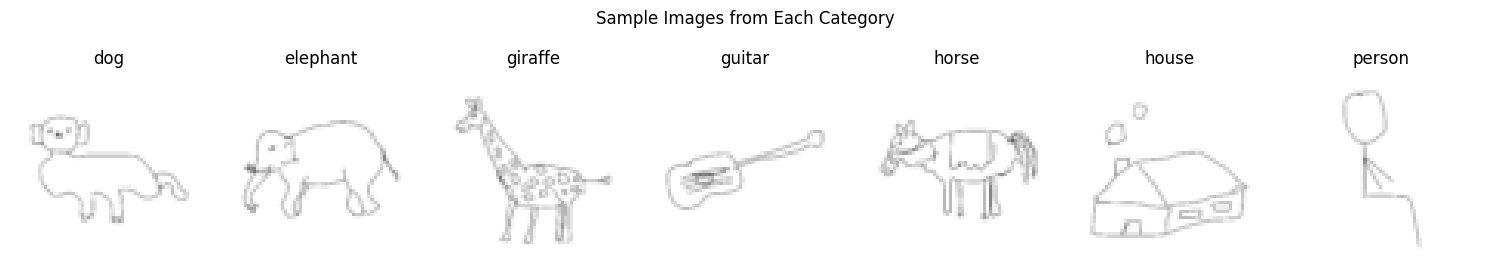

In [26]:
visualize_example_images(root_dir, 'sketch')

In [36]:
# Load ResNet50 model pre-trained on ImageNet
model = models.resnet50(weights='ResNet50_Weights.DEFAULT')

# Modify the last fully connected layer for 7 classes (PACS has 7 classes)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 7)

In [37]:
# Instantiate loss, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.1)

Epoch 1/10: 100%|████████████████████████████████████████████████████████████████████| 261/261 [00:30<00:00,  8.66it/s]


Epoch [1/10], Loss: 1.1260, Test Accuracy: 73.95%, Learning Rate: 0.000000


Epoch 2/10: 100%|████████████████████████████████████████████████████████████████████| 261/261 [00:30<00:00,  8.66it/s]


Epoch [2/10], Loss: 1.1268, Test Accuracy: 72.63%, Learning Rate: 0.000000


Epoch 3/10: 100%|████████████████████████████████████████████████████████████████████| 261/261 [00:30<00:00,  8.68it/s]


Epoch [3/10], Loss: 1.1168, Test Accuracy: 70.84%, Learning Rate: 0.000000


Epoch 4/10: 100%|████████████████████████████████████████████████████████████████████| 261/261 [00:30<00:00,  8.47it/s]


Epoch [4/10], Loss: 1.1199, Test Accuracy: 72.16%, Learning Rate: 0.000000


Epoch 5/10: 100%|████████████████████████████████████████████████████████████████████| 261/261 [00:30<00:00,  8.61it/s]


Epoch [5/10], Loss: 1.1275, Test Accuracy: 73.29%, Learning Rate: 0.000000


Epoch 6/10: 100%|████████████████████████████████████████████████████████████████████| 261/261 [00:29<00:00,  8.72it/s]


Epoch [6/10], Loss: 1.1308, Test Accuracy: 72.69%, Learning Rate: 0.000000


Epoch 7/10: 100%|████████████████████████████████████████████████████████████████████| 261/261 [00:30<00:00,  8.58it/s]


Epoch [7/10], Loss: 1.1284, Test Accuracy: 72.51%, Learning Rate: 0.000000


Epoch 8/10: 100%|████████████████████████████████████████████████████████████████████| 261/261 [00:29<00:00,  8.78it/s]


Epoch [8/10], Loss: 1.1349, Test Accuracy: 70.96%, Learning Rate: 0.000000


Epoch 9/10: 100%|████████████████████████████████████████████████████████████████████| 261/261 [00:30<00:00,  8.62it/s]


Epoch [9/10], Loss: 1.1337, Test Accuracy: 73.77%, Learning Rate: 0.000000


Epoch 10/10: 100%|███████████████████████████████████████████████████████████████████| 261/261 [00:29<00:00,  8.72it/s]


Epoch [10/10], Loss: 1.1308, Test Accuracy: 74.49%, Learning Rate: 0.000000
Finished Training


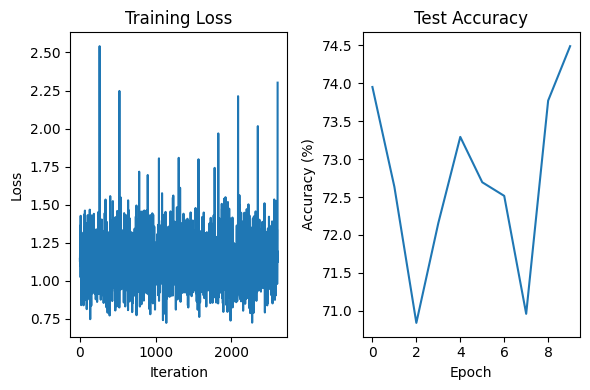

In [43]:
if not TEST_MODE:
	device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

	model = model.to(device)

	# Lists to store loss and accuracy values
	train_losses = []
	test_accuracies = []

	for epoch in range(num_epochs):
		model.train()
		running_loss = 0.0
		correct = 0
		total = 0

		for i, (inputs, labels) in enumerate(tqdm(loader_train, desc=f'Epoch {epoch+1}/{num_epochs}')):
			inputs, labels = inputs.to(device), labels.to(device)

			optimizer.zero_grad()

			outputs = model(inputs)
			loss = criterion(outputs, labels)
			loss.backward()
			optimizer.step()

			running_loss += loss.item()
			_, predicted = outputs.max(1)
			total += labels.size(0)
			correct += predicted.eq(labels).sum().item()

			# Store loss at every iteration
			train_losses.append(loss.item())
			
		scheduler.step()

		# Validation
		model.eval()
		correct = 0
		total = 0
		with torch.no_grad():
			for inputs, labels in loader_test:
				inputs, labels = inputs.to(device), labels.to(device)
				outputs = model(inputs)
				_, predicted = outputs.max(1)
				total += labels.size(0)
				correct += predicted.eq(labels).sum().item()

		test_accuracy = 100 * correct / total
		test_accuracies.append(test_accuracy)
	
		current_lr = optimizer.param_groups[0]['lr']
		print(f'Epoch [{epoch+1}/{num_epochs}], '
					f'Loss: {running_loss/len(loader_train):.4f}, '
					f'Test Accuracy: {test_accuracy:.2f}%, '
					f'Learning Rate: {current_lr:.6f}')

	print('Finished Training')

	# Save the model - make sure you include this file in your submission
	torch.save(model.state_dict(), f'./{model_name}')

	# Plotting after training is finished
	plt.figure(figsize=(6, 4))

	# Plot training loss
	plt.subplot(1, 2, 1)
	plt.plot(train_losses)
	plt.title('Training Loss')
	plt.xlabel('Iteration')
	plt.ylabel('Loss')

	# Plot test accuracy
	plt.subplot(1, 2, 2)
	plt.plot(test_accuracies)
	plt.title('Test Accuracy')
	plt.xlabel('Epoch')
	plt.ylabel('Accuracy (%)')

	plt.tight_layout()
	plt.show()

Before changing the Transform_train 

1. Vanilla transform
Epoch [10/10], Loss: 0.8679, Test Accuracy: 64.19%, Learning Rate: 0.000010
Finished Training

2. After Changing the Transfomr_train (with Gaussian blur in transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)))
transform_train = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomRotation(degrees=10),
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Epoch [10/10], Loss: 1.1590, Test Accuracy: 69.16%, Learning Rate: 0.000010
Finished Trainin

3. After Changing the Transfomr_train (without Gaussian Blur/ adding grayscale, image rotation)
transform_train = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Epoch [10/10], Loss: 1.1301, Test Accuracy: 72.34%, Learning Rate: 0.000001
Finished Training
4. 
addingEdge-Preserving Filter ()snsform_train 설정
transform_train = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    EdgePreservingFilter(),  # Edge-Preserving 필터 추가
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.2Epoch [10/10], Loss: 1.1308, Test Accuracy: 74.49%, Learning Rate: 0.000000
Finished Trainin

-------------------
g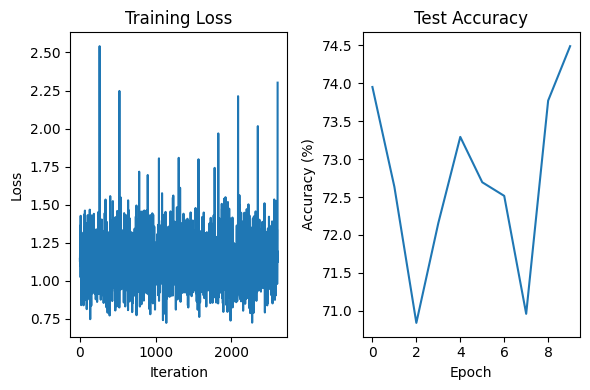29, 0.224, 0.225]),
])


g


In [42]:
import cv2
import numpy as np
from torchvision import transforms
from PIL import Image

class EdgePreservingFilter:
    def __call__(self, img):
        img_np = np.array(img)
        filtered_img = cv2.bilateralFilter(img_np, d=9, sigmaColor=75, sigmaSpace=75)
        return Image.fromarray(filtered_img)

transform_train = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    EdgePreservingFilter(),  # Edge-Preserving 필터 추가
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [39]:
# Test code - DO NOT RUN, and DO NOT MODIFY.
# TAs will evaluate your model using their curated dataset.
if TEST_MODE:
	del model
	model = models.resnet50()
	model.load_state_dict(torch.load(f'./{model_name}'))
	
	root_dir_test = '/work/datasets/CuratedPACS'

	class CustomDataset(Dataset):
		def __init__(self, root_dir, transform=None):
			self.root_dir = root_dir
			self.transform = transform
			self.images = []
			self.labels = []
			self.class_to_idx = {'dog': 0, 'elephant': 1, 'giraffe': 2, 'guitar': 3, 'horse': 4, 'house': 5, 'person': 6}
			self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}
			for cls_name in self.class_to_idx.keys:
				cls_dir = os.path.join(self.root_dir, cls_name)
				for img_name in os.listdir(cls_dir):
					self.images.append(os.path.join(cls_dir, img_name))
					self.labels.append(self.class_to_idx[cls_name])
			
		def __len__(self):
			return len(self.images)

	dataset_test = CustomDataset(root_dir, transform=transform_test)

	# Peform test with the test dataset
	correct = 0
	total = 0
	with torch.no_grad():
		for inputs, labels in loader_test:
			inputs, labels = inputs.to(device), labels.to(device)
			outputs = model(inputs)
			_, predicted = outputs.max(1)
			total += labels.size(0)
			correct += predicted.eq(labels).sum().item()

	print(f'Test Accuracy: {100 * correct / total:.2f}%')